In [22]:
import pickle
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
from tqdm import tqdm
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
from tensorflow.contrib.layers import flatten
from IPython.display import HTML, display
import os
import pandas as pd
from sklearn import preprocessing
%matplotlib inline

In [ ]:
"""
Functions for embeding tensorboard in Jupyter
"""
def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script src="//cdnjs.cloudflare.com/ajax/libs/polymer/0.3.3/platform.js"></script>
        <script>
              function load() {{
                document.getElementById("{id}").pbtxt = {data};
              }}
        </script>
        
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        
        <div style="height:600px">
              <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

In [140]:
# The code is from aleje. ref: https://github.com/aleju/imgaug
"""
Data augmentation

args: 
i: input images
o: the name of output file
m: minimum number of images for each class

yields:
images aftef affine transformation
"""
! python utility/dataAugmentation.py -i 'datasets//train.p' -o 'datasets//aug_train.p' -m 600

## Examples of data after data augmentation

In [2]:
display(HTML("<table><tr><td>Origin image</td><td>Affine Transformed images</td></tr> <tr><td><img src='./img/sample_traffic_sign.jpg' style='width: 500px;'></td><td><img src='./img/dataAugment.png' style='width: 500px;'></td></tr></table>"))

Origin image,Affine Transformed images
,


In [23]:
def read_data_sets(file):
    """
    Load pickled data
    args:
        file   (str)     path to datasets 
    yields:
        features and label of datasets (numpy array)
    """
    with open(file, mode='rb') as f:
        return pickle.load(f)

In [24]:
data_rel_path = "..\\..\\datasets_collection\\Traffic_Sign_Classifier"

train = read_data_sets(os.path.join(data_rel_path, "aug_train.p"))
valid= read_data_sets(os.path.join(data_rel_path, "valid.p")) 
test = read_data_sets(os.path.join(data_rel_path, "test.p")) 

signNames_pd = pd.read_csv(os.path.join(data_rel_path, "signnames.csv"))

In [25]:
image_shape = train['features'][0].shape
n_classes = len(signNames_pd["ClassId"])

In [26]:
def normalize(images):
    m = images.shape[0]
    flat_img = images.reshape((m,-1))
    _min = np.amin(images, axis=(1,2,3)).reshape(m,-1)
    _max = np.amax(images, axis=(1,2,3)).reshape(m,-1)
    norm_imgs = ((flat_img - _min) / (_max - _min))
    return norm_imgs.reshape(images.shape)

train['features'] = normalize(train['features']) 
test['features'] = normalize(test['features'])
valid['features'] = normalize(valid['features'])

In [27]:
def OneHotEncoding(y_class):
    lb = preprocessing.LabelBinarizer()
    lb.fit(y_class)
    return lb

In [28]:
ohe = OneHotEncoding(signNames_pd["ClassId"])

In [29]:
train['labels'] = ohe.transform(train['labels']).astype(np.float64)
valid['labels'] = ohe.transform(valid['labels']).astype(np.float64)
test['labels'] = ohe.transform(test['labels']).astype(np.float64)

In [30]:
from sklearn.model_selection import train_test_split
"""
data shuffeling
"""
train['features'], valid['features'], train['labels'], valid['labels'] = train_test_split( train['features'], 
                                                                                           train['labels'],
                                                                                           test_size=0.2,
                                                                                           random_state=1)    

In [31]:
"""
Set neural network parameters
"""
EPOCHS = 4
BATCH_SIZE = 150
LEARNING_RATE = 0.0001

layer_width = {
    'conv1': 32,
    'conv2': 128,
    'fc1': 1024,
    'fc2': 1024,
    'fc3': n_classes
}
filter_size=[3,3]

for key,val in sorted(layer_width.items()):
    print("Layer %4s width is %s"%(key,val))
          
for key,val in sorted(weights.items()):
    print("Weights for %4s: %s"%(key,val))

Layer conv1 width is 32
Layer conv2 width is 128
Layer  fc1 width is 1024
Layer  fc2 width is 1024
Layer  fc3 width is 43
Weights for conv1: <tf.Variable 'karol/conv1w:0' shape=(3, 3, 3, 32) dtype=float32_ref>
Weights for conv2: <tf.Variable 'karol/conv2w:0' shape=(3, 3, 32, 128) dtype=float32_ref>
Weights for  fc1: <tf.Variable 'karol/fc1w:0' shape=(131072, 1024) dtype=float32_ref>
Weights for  fc2: <tf.Variable 'karol/fc2w:0' shape=(1024, 1024) dtype=float32_ref>
Weights for  fc3: <tf.Variable 'karol/fc3w:0' shape=(1024, 43) dtype=float32_ref>


In [32]:
def conv2d(x, W, b, strides=1):
    # Conv2D wrapper, with bias and relu activation
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)

def maxpool2d(x, k=2):
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1], padding='SAME')

def fclayer(x,w,b):
    return tf.nn.xw_plus_b(tf.contrib.layers.flatten(x), w, b)

In [33]:
def myNet(x):
    # conv layer
    net = conv2d(x,weights['conv1'],biases['conv1'])
    net = conv2d(net,weights['conv2'],biases['conv2'])

    # fully connected layers
    net = fclayer(net,weights['fc1'],biases['fc1'])
    net = tf.nn.relu(net)
    net = fclayer(net,weights['fc2'],biases['fc2'])
    net = tf.nn.relu(net)
    net = fclayer(net,weights['fc3'],biases['fc3'])

    return net

In [34]:
# ref: https://github.com/aymericdamien/TensorFlow-Examples/blob/master/examples/4_Utils/tensorboard_basic.py

# Initializing the variables
# init = tf.global_variables_initializer()



tf.reset_default_graph()
g = tf.Graph()
with g.as_default():
    x = tf.placeholder(tf.float32, shape=[None,image_shape[0],image_shape[1],image_shape[2]])
    y = tf.placeholder(tf.float32)

    with tf.variable_scope('karol', reuse=False):
        weights = {
            'conv1': tf.get_variable("conv1w", shape=[filter_size[0], filter_size[1], image_shape[2], layer_width['conv1']], initializer=tf.contrib.layers.xavier_initializer()),
            'conv2': tf.get_variable("conv2w", shape=[filter_size[0], filter_size[1], layer_width['conv1'], layer_width['conv2']], initializer=tf.contrib.layers.xavier_initializer()),
            'fc1':  tf.get_variable("fc1w", shape=[image_shape[0]*image_shape[1]*layer_width['conv2'], layer_width['fc1']], initializer=tf.contrib.layers.xavier_initializer()),
            'fc2':  tf.get_variable("fc2w", shape=[layer_width['fc1'], layer_width['fc2']], initializer=tf.contrib.layers.xavier_initializer()),
            'fc3':  tf.get_variable("fc3w", shape=[layer_width['fc2'], layer_width['fc3']], initializer=tf.contrib.layers.xavier_initializer())
        }

        biases = {
            'conv1': tf.get_variable("conv1b", shape=[layer_width['conv1']], initializer=tf.contrib.layers.xavier_initializer()),
            'conv2': tf.get_variable("conv2b", shape=[layer_width['conv2']], initializer=tf.contrib.layers.xavier_initializer()),
            'fc1': tf.get_variable("fc1b", shape=[layer_width['fc1']], initializer=tf.contrib.layers.xavier_initializer()),
            'fc2': tf.get_variable("fc2b", shape=[layer_width['fc2']], initializer=tf.contrib.layers.xavier_initializer()),
            'fc3': tf.get_variable("fc3b", shape=[layer_width['fc3']], initializer=tf.contrib.layers.xavier_initializer())
        }


    with tf.name_scope('Model'):
        net = myNet(x)

    # Loss computation
    with tf.name_scope('Loss'):
        prediction = tf.nn.softmax(net)
        cross_entropy = -tf.reduce_sum(y * tf.log(prediction + 1e-6), reduction_indices=1)
        loss = tf.reduce_mean(cross_entropy)

    # Accuracy computation
    with tf.name_scope('Accuracy'):
        is_correct_prediction = tf.equal(tf.argmax(prediction, 1), tf.argmax(y, 1))
        accuracy = tf.reduce_mean(tf.cast(is_correct_prediction, tf.float32))
    with tf.name_scope('SGD'):
        optimizer = tf.train.AdamOptimizer(LEARNING_RATE).minimize(loss)        
        
    # Create a summary to monitor cost tensor
    tf.summary.scalar("loss", loss)
    # Create a summary to monitor accuracy tensor
    tf.summary.scalar("accuracy", accuracy)
    # Merge all summaries into a single op
    merged_summary_op = tf.summary.merge_all()
#     tf.summary.FileWriter("logs", g).close()

In [36]:
batches = []
loss_epoch = []
train_acc_epoch = []
valid_acc_epoch = []
validation_accuracy = 0.0

batch_count = int(len(train['features']) / BATCH_SIZE)

# Start training
with tf.Session(graph=g, config=tf.ConfigProto(log_device_placement=True)) as sess:
    # Initialize the variables (i.e. assign their default value)
    init = tf.global_variables_initializer()

    # Run the initializer
    sess.run(init)

    # op to write logs to Tensorboard
    train_writer = tf.summary.FileWriter("logs", g)

    for epoch in range(EPOCHS):
        batches_pbar = tqdm(range(batch_count), desc='Epoch {:>2}/{}'.format(epoch + 1, EPOCHS), unit='batches')

        for batch_i in batches_pbar:
            batch_start = batch_i * BATCH_SIZE
            batch_features = train['features'][batch_start:batch_start + BATCH_SIZE]
            batch_labels = train['labels'][batch_start:batch_start + BATCH_SIZE]

            _, l, summary = sess.run(
                [optimizer, loss, merged_summary_op],
                feed_dict={x: batch_features, y: batch_labels})
            
            summary_writer.add_summary(summary, epoch * BATCH_SIZE + batch_i)

        training_accuracy = sess.run(
            accuracy,
            feed_dict={x: batch_features, y: batch_labels}
        )

        idx = np.random.randint(len(valid['features']), size=int(BATCH_SIZE * .2))

        validation_accuracy = sess.run(
            accuracy,
            feed_dict={x: valid['features'][idx,:], y: valid['labels'][idx,:]}
        )

        print('Epoch {:>2}/{}'.format(epoch + 1, EPOCHS))
        print(l)
        print(training_accuracy)
        print(validation_accuracy)


        batches.append(len(batches))
        loss_epoch.append(l)
        train_acc_epoch.append(training_accuracy)
        valid_acc_epoch.append(validation_accuracy)


Epoch  1/4: 100%|███████████████████████| 221/221 [11:26<00:00,  2.80s/batches]


Epoch  1/4
0.731818
0.846667
0.733333


Epoch  2/4: 100%|███████████████████████| 221/221 [10:41<00:00,  2.93s/batches]


Epoch  2/4
0.35015
0.933333
0.9


Epoch  3/4: 100%|███████████████████████| 221/221 [11:10<00:00,  3.02s/batches]


Epoch  3/4
0.201726
0.966667
0.933333


Epoch  4/4: 100%|███████████████████████| 221/221 [10:47<00:00,  2.84s/batches]


Epoch  4/4
0.125585
0.973333
0.966667


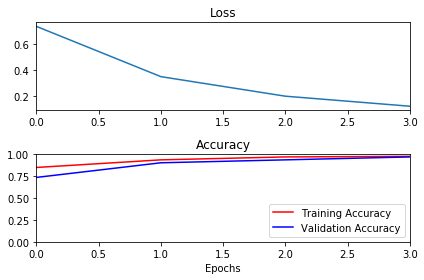

In [37]:
loss_plot = plt.subplot(211)
loss_plot.set_title('Loss')
loss_plot.plot(batches, loss_epoch)
loss_plot.set_xlim([batches[0], batches[-1]])
acc_plot = plt.subplot(212)
acc_plot.set_title('Accuracy')
acc_plot.plot(batches, train_acc_epoch, 'r', label='Training Accuracy')
acc_plot.plot(batches, valid_acc_epoch, 'b', label='Validation Accuracy')
acc_plot.set_xlabel('Epochs')
acc_plot.set_ylim([0, 1.0])
acc_plot.set_xlim([batches[0], batches[-1]])
acc_plot.legend(loc=4)
plt.tight_layout()
plt.show()

In [46]:
display(HTML("<table><tr><td>Origin image</td><td>Model graph</td></tr> <tr><td><img src='./img/Model_architecture_2.PNG' style='width: 700px;'></td><td><img src='./img/Model_architecture.png' style='width: 700px;'></td></tr></table>"))

Origin image,Model graph
,


In [39]:
show_graph(g)